# The spelled-out intro to neural networks and backpropagation: building micrograd

## Derivative of a simple function with one input

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

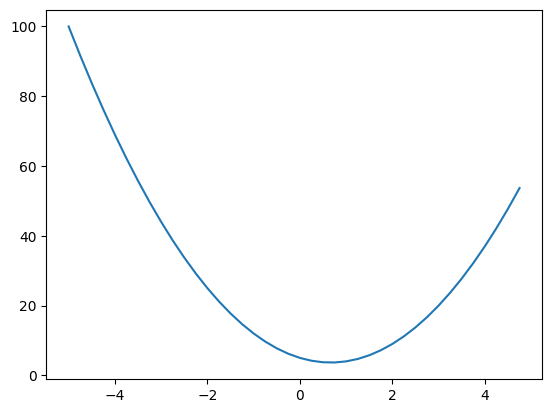

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 3.0
print(f(x))
print(f(x + h))

20.0
20.000014000003002


### Slope

In [6]:
def slope_at(x):
    return (f(x + h) - f(x)) / h

In [7]:
print(slope_at(3.0))
print(slope_at(-3.0))
print(slope_at(2/3))

14.000003002223593
-21.999997002808414
2.999378523327323e-06


## Derivative of a function with multiple inputs

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a1 = 2.0
b = -3.0
c = 10.0

d1 = a1 * b + c
a2 = a1 + h

d2 = a2 * b + c

print('h', h)
print('a1', a1)
print('a2', a2)
print('a2 - a1', a2 - a1)
print('d1', d1)
print('d2', d2)
print('d2 - d1', d2 - d1)
print('(d2 - d1) / (a2 - a1)', (d2 - d1) / (a2 - a1))
print('(d2 - d1) / h', (d2 - d1) / h)

h 0.0001
a1 2.0
a2 2.0001
a2 - a1 0.00010000000000021103
d1 4.0
d2 3.999699999999999
d2 - d1 -0.0003000000000010772
(d2 - d1) / (a2 - a1) -3.000000000004441
(d2 - d1) / h -3.000000000010772


## Starting at the core Value object of micrograd and its visualization

### Value class

In [10]:
class Value:

    def __init__(self, data, _label=None, _op=None, _children=()) -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._label = _label
        self._exp_label = None

        if _op != None:
            if len(_children) == 1:
                if _children[0]._label == None:
                    if _children[0]._exp_label != None:
                        child_label = f"{_children[0]._exp_label}"
                    else:
                        child_label = f"{_children[0].data}"
                else:
                    child_label = _children[0]._label
                self._exp_label = f"{_op}({child_label})"
            elif len(_children) == 2:
                if _children[0]._label == None:
                    if _children[0]._exp_label != None:
                        if len(_children[0]._prev) > 1:
                            child_1_label = f"({_children[0]._exp_label})"
                        else:
                            child_1_label = f"{_children[0]._exp_label}"
                    else:
                        child_1_label = f"{_children[0].data}"
                else:
                    child_1_label = _children[0]._label
                if _children[1]._label == None:
                    if _children[1]._exp_label != None:
                        child_2_label = f"({_children[1]._exp_label})"
                    else:
                        child_2_label = f"{_children[1].data}"
                else:
                    child_2_label = _children[1]._label
                self._exp_label = f"{child_1_label} {_op} {child_2_label}"

        self._prev = _children
        self._op = _op

    def label(self, _label):
        self._label = _label
        return self

    def __repr__(self) -> str:
        out = "%.4f" % self.data
        if self._label != None:
            out = f"{self._label}={out}"
        if self._exp_label != None:
            out = f"{out} [{self._exp_label}]"
        return out

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
        out = Value(
            data=self.data + other.data,
            _op="+",
            _children=(self, other)
        )

        def _backward():
            # d(self+other)/dself = 1
            self.grad += out.grad
            # d(self+other)/dother = 1
            other.grad += out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return Value(other) + self

    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
        out = Value(
            data=self.data - other.data,
            _op="-",
            _children=(self, other)
        )

        def _backward():
            # d(self-other)/dself = 1
            self.grad += out.grad
            # d(self-other)/dother = -1
            other.grad -= out.grad
        out._backward = _backward

        return out

    def __rsub__(self, other):
        return Value(other) - self

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
        out = Value(
            data=self.data * other.data,
            _op="*",
            _children=(self, other)
        )

        def _backward():
            # d(self*other)/dself = other
            self.grad += other.data * out.grad
            # d(self*other)/dother = self
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return Value(other) * self

    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
        out = Value(
            data=self.data / other.data,
            _op="/",
            _children=(self, other)
        )

        def _backward():
            # d(self/other)/dself = 1/other
            self.grad += out.grad / other.data
            # d(self/other)/dother = -self/other**2
            other.grad -= (self.data * out.grad) / (other.data**2)
        out._backward = _backward

        return out

    def __rtruediv__(self, other):
        return Value(other) / self

    def __pow__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
            out = Value(
                data=self.data ** other.data,
                _op="**",
                _children=(self, other)
            )

            def _backward():
                # d(self**other)/dself = other * self**(other-1)
                self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
                
                if self.data > 0:
                    # d(self**other)/dother = (self**other) * log(self)
                    other.grad += (self.data ** other.data) * math.log(self.data) * out.grad
                else:
                    # Handle the case where self.data <= 0 appropriately, if necessary
                    pass
            out._backward = _backward

        return out

    def __rpow__(self, other):
        return Value(other) ** self

    def exp(self):
        out = Value(
            data=math.exp(self.data),
            _op="exp",
            _children=(self,)
        )

        def _backward():
            # d(exp(self))/dself = exp(self)
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self
        t = (((2*n).exp() - 1) / ((2*n).exp() + 1)).data
        out = Value(
            data=t,
            _op="tanh",
            _children=(self,)
        )

        def _backward():
            # d(tanh(self))/dself = 1 - tanh**2
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):
        out = Value(-self.data)
        if self._label == None and self._exp_label != None and len(self._prev) > 1:
            out._exp_label = f"-({self._exp_label})"
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def my_backward(self):
        self._backward()
        for child in self._prev:
            child.my_backward()


### Defining the expression

In [11]:
a = Value(2.0).label("a")
b = Value(-3.0).label("b")
c = Value(10.0).label("c")
e = (a * b).label("e")
d = (e + c).label("d")
f = Value(-2.0).label("f")
L = (d * f).label("L")
print(a)
print(b)
print(c)
print(e)
print(d)
print(f)
print(L)

a=2.0000
b=-3.0000
c=10.0000
e=-6.0000 [a * b]
d=4.0000 [e + c]
f=-2.0000
L=-8.0000 [d * f]


### Graph drawing function

In [12]:
from graphviz import Digraph


def trace(root):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        n_label = n._label if n._label != None else n._exp_label if n._exp_label != None else n.data
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" %
                 (n_label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


### Visualizing the graph of the expression

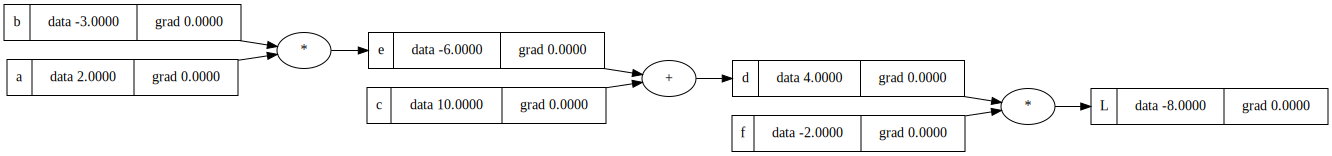

In [13]:
draw_dot(L)

## Manual backpropagation example #1: simple expression

### Gating function. Calculating the gradient values.
Reason: To avoid the polution of the global scope. All the variables are locally defined in the function.

In [14]:
def lol():
    h = 0.001
    a = Value(2.0).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0).label("c")
    e = (a * b).label('e')
    d = (e + c).label('d')
    f = Value(-2.0).label("f")
    L = (d * f).label('L')

    ###############
    # dL/dL = 1.0 #
    ###############
    a = Value(2.0).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0).label("c")
    e = (a * b).label('e')
    d = (e + c).label('d')
    f = Value(-2.0).label("f")
    L_L = (d * f + h).label("L_L")

    # 1. dL/dL = 1.0
    # 2. L(d, f) = d * f
    # 3. L(d, f) + h = d * f + h
    # 4. L'_L(d, f) = (L(d, f) + h - L(d, f)) / h
    # 5. L'_L(d, f) = (d * f + h - d * f) / h
    # 6. L'_L(d, f) = h / h = 1
    print(f"dL/dL = {(L_L - L) / h}")

    ###############
    # dL/da = 6.0 #
    ###############
    a = Value(2.0 + h).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0).label("c")
    e = (a * b).label('e')
    d = (e + c).label('d')
    f = Value(-2.0).label("f")
    L_a = (d * f).label('L_a')

    # 1. dL/da = b * f = -3.0 * -2.0 = 6.0
    # 2. L(d, f) = d * f
    # 3. L(e, c, f) = (e + c) * f
    # 4. L(a, b, c, f) = (a * b + c) * f
    # 5. L(a + h, b, c, f) = ((a + h) * b + c) * f
    # 6. L'_a(a, b, c, f) = (L(a + h, b, c, f) - L(a, b, c, f)) / h
    # 7. L'_a(a, b, c, f) = (((a + h) * b + c) * f - (a * b + c) * f) / h
    # 8. L'_a(a, b, c, f) = ((a * b + h * b + c) * f - (a * b + c) * f) / h
    # 9. L'_a(a, b, c, f) = ((a * b * f) + h * b * f + (c * f) - (a * b * f) - (c * f)) / h
    # A. L'_a(a, b, c, f) = (h * b * f) / h = b * f
    print(f"dL/da = {(L_a - L) / h}")

    ################
    # dL/db = -4.0 #
    ################
    a = Value(2.0).label("a")
    b = Value(-3.0 + h).label("b")
    c = Value(10.0).label("c")
    e = (a * b).label('e')
    d = (e + c).label('d')
    f = Value(-2.0).label("f")
    L_b = (d * f).label('L_b')

    # 1. dL/db = a * f = 2.0 * -2.0 = -4.0
    # 2. L(d, f) = d * f
    # 3. L(e, c, f) = (e + c) * f
    # 4. L(a, b, c, f) = (a * b + c) * f
    # 5. L(a, b + h, c, f) = (a * (b + h) + c) * f
    # 6. L'_b(a, b, c, f) = (L(a, b + h, c, f) - L(a, b, c, f)) / h
    # 7. L'_b(a, b, c, f) = ((a * (b + h) + c) * f - (a * b + c) * f) / h
    # 8. L'_b(a, b, c, f) = ((a * b + a * h + c) * f - (a * b * f + c * f)) / h
    # 9. L'_b(a, b, c, f) = ((a * b * f) + a * h * f + (c * f) - (a * b * f) - (c * f)) / h
    # 9. L'_b(a, b, c, f) = (a * h * f) / h = a * f
    print(f"dL/db = {(L_b - L) / h}")

    ################
    # dL/dc = -2.0 #
    ################
    a = Value(2.0).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0 + h).label("c")
    e = (a * b).label('e')
    d = (e + c).label('d')
    f = Value(-2.0).label("f")
    L_c = (d * f).label('L_c')

    # 1. dL/dc = f = -2.0
    # 2. L(d, f) = d * f
    # 3. L(e, c, f) = (e + c) * f
    # 4. L(e, c + h, f) = (e + c + h) * f
    # 5. L'_c(e, c, f) = (L(e, c + h, f) - L(e, c, f)) / h
    # 6. L'_c(e, c, f) = ((e + c + h) * f - (e + c) * f) / h
    # 7. L'_c(e, c, f) = ((e * f) + (c * f) + h * f - (e * f) - (c * f)) / h
    # 8. L'_c(e, c, f) = (h * f) / h = f
    print(f"dL/dc = {(L_c - L) / h}")

    ################
    # dL/de = -2.0 #
    ################
    a = Value(2.0).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0).label("c")
    e = (a * b + h).label('e')
    d = (e + c).label('d')
    f = Value(-2.0).label("f")
    L_e = (d * f).label("L_e")

    # 1. dL/de = f = -2.0
    # 2. L(d, f) = d * f
    # 3. L(e, c, f) = (e + c) * f
    # 4. L(e + h, c, f) = (e + h + c) * f
    # 5. L'_e(e, c, f) = (L(e + h, c, f) - L(e, c, f)) / h
    # 6. L'_e(e, c, f) = ((e + h + c) * f - (e + c) * f) / h
    # 7. L'_e(e, c, f) = (h * f) / h = f
    print(f"dL/de = {(L_e - L) / h}")

    ################
    # dL/dd = -2.0 #
    ################
    a = Value(2.0).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0).label("c")
    e = (a * b).label('e')
    d = (e + c + h).label('d')
    f = Value(-2.0).label("f")
    L_d = (d * f).label("L_d")

    # 1. dL/dd = f = -2.0
    # 2. L(d, f) = d * f
    # 3. L(d + h, f) = (d + h) * f
    # 4. L'_d(d, f) = (L(d + h, f) - L(d, f)) / h
    # 5. L'_d(d, f) = ((d + h) * f - d * f) / h
    # 6. L'_d(d, f) = (d * f + f * h - d * f) / h
    # 7. L'_d(d, f) = (f * h) / h = f
    print(f"dL/dd = {(L_d - L) / h}")

    ###############
    # dL/df = 4.0 #
    ###############
    a = Value(2.0).label("a")
    b = Value(-3.0).label("b")
    c = Value(10.0).label("c")
    e = (a * b).label('e')
    d = (e + c).label('d')
    f = Value(-2.0 + h).label("f")
    L_f = (d * f).label("L_f")

    # 1. dL/df = d = e + c = a * b + c = (2 * -3) + 10 = -6 + 10 = 4.0
    # 2. L(d, f) = d * f
    # 3. L(d, f + h) = (d + h) * f
    # 4. L'_f(d, f) = (L(d, f + h) - L(d, f)) / h
    # 5. L'_f(d, f) = (d * (f + h) - d * f) / h
    # 6. L'_f(d, f) = (d * f + d * h - d * f) / h
    # 7. L'_f(d, f) = (d * h) / h = d
    print(f"dL/df = {(L_f - L) / h}")


lol()


dL/dL = 1.0000 [(L_L - L) / 0.001]
dL/da = 6.0000 [(L_a - L) / 0.001]
dL/db = -4.0000 [(L_b - L) / 0.001]
dL/dc = -2.0000 [(L_c - L) / 0.001]
dL/de = -2.0000 [(L_e - L) / 0.001]
dL/dd = -2.0000 [(L_d - L) / 0.001]
dL/df = 4.0000 [(L_f - L) / 0.001]


### Setting the calculated gradient values

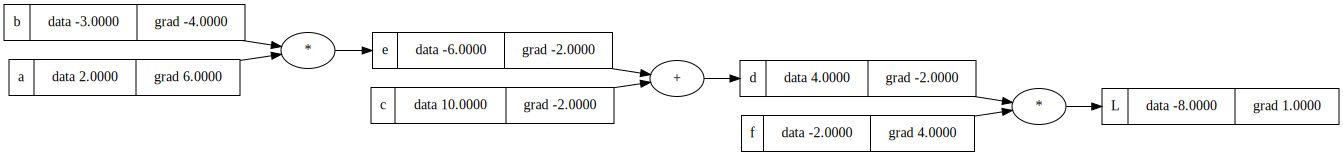

In [15]:
L.grad = 1.0
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0

draw_dot(L)

### Preview of a single optimization step

-7.2865


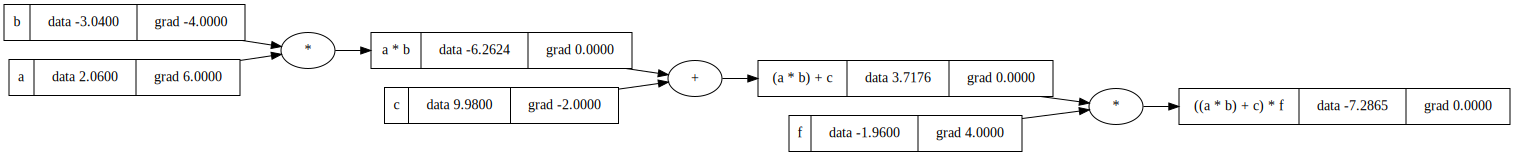

In [16]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print("%.4f" % L.data)
draw_dot(L)

## Manual backpropagation example #2: a neuron

### Activation function

#### np.tanh()

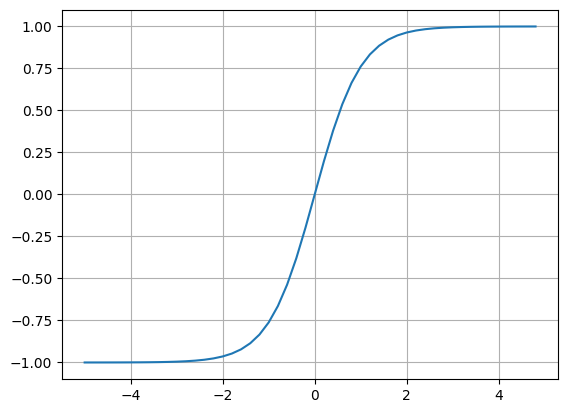

In [17]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

#### Value.tanh()

In [18]:
n = Value(0.5).label("n")
# t = ((2*n).exp() - 1) / ((2*n).exp() + 1)
n.tanh()

0.4621 [tanh(n)]

### Backpropagation

In [19]:
# inputs x1, x2
x1 = Value(2.0).label("x1")
x2 = Value(0.0).label("x2")
# weights w1, w2
w1 = Value(-3.0).label("w1")
w2 = Value(1.0).label("w2")
# bias of the neuron
b = Value(6.8813735870195432).label("b")
# x1*w1 + x2*w2 + b
x1w1 = (x1 * w1).label("x1*w1")
x2w2 = (x2 * w2).label("x2*w2")
x1w1x2w2 = (x1w1 + x2w2).label("x1*w1 + x2*w2")
n = (x1w1x2w2 + b).label("n")
o = n.tanh().label("o")
print(n)
print(o)

n=0.8814 [x1*w1 + x2*w2 + b]
o=0.7071 [tanh(n)]


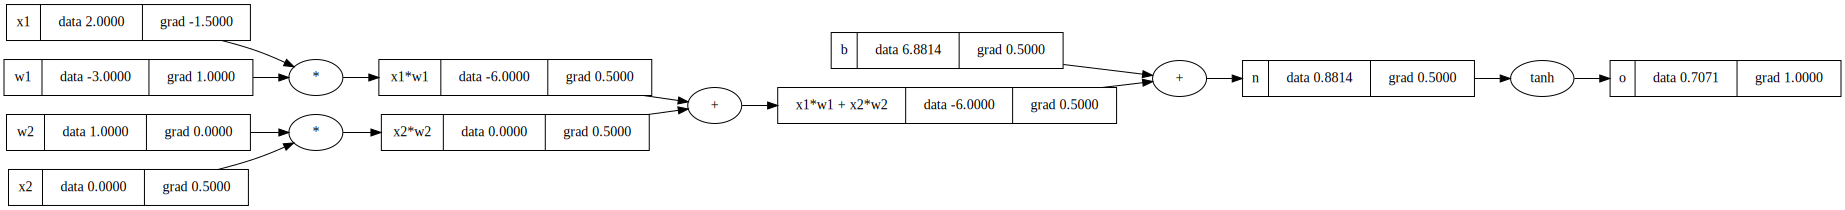

In [20]:
o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh(n) ** 2 = 1 - o ** 2
# do/dn = 0.5
n.grad = 0.5

# d/dx f(x) = (f(x + h) - f(x)) / h

# n = x1w1x2w2 + b
# dn/dx1w1x2w2 = ((x1w1x2w2 + b + h) - (x1w1x2w2 + b)) / h
# dn/dx1w1x2w2 = (x1w1x2w2 + b + h - x1w1x2w2 - b) / h
# dn/dx1w1x2w2 = h / h = 1.0
# do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2 = 0.5 * 1.0 = 0.5
# do/dx1w1x2w2 = 0.5
x1w1x2w2.grad = 0.5

# dn/db = ((x1w1x2w2 + b) - (x1w1x2w2 + b + h)) / h
# dn/db = (x1w1x2w2 + b - x1w1x2w2 - b - h) / h
# dn/db = h / h = 1.0
# do/db = do/dn * dn/db = 0.5 * 1.0 = 0.5
# do/db = 0.5
b.grad = 0.5

# x1w1x2w2 = x1w1 + x2w2
# dx1w1x2w2/dx2w2 = ((x1w1 + x2w2 + h) - (x1w1 + x2w2)) / h
# dx1w1x2w2/dx2w2 = (x1w1 + x2w2 + h - x1w1 - x2w2) / h
# dx1w1x2w2/dx2w2 = h / h = 1.0
# do/dx2w2 = do/dx1w1x2w2 * dx1w1x2w2/dx2w2 = 0.5 * 1.0 = 0.5
# do/dx2w2 = 0.5
x2w2.grad = 0.5

# x1w1x2w2 = x1w1 + x2w2
# dx1w1x2w2/dx1w1 = ((x1w1 + h + x2w2) - (x1w1 + x2w2)) / h
# dx1w1x2w2/dx1w1 = (x1w1 + h + x2w2 - x1w1 - x2w2) / h
# dx1w1x2w2/dx1w1 = h / h = 1.0
# do/dx1w1 = do/dx1w1x2w2 * dx1w1x2w2/dx1w1 = 0.5 * 1.0 = 0.5
# do/dx1w1 = 0.5
x1w1.grad = 0.5

# x2w2 = x2 * w2
# dx2w2/dx2 = (((x2 + h) * w2) - (x2 * w2)) / h
# dx2w2/dx2 = (x2 * w2 + h * w2 - x2 * w2) / h
# dx2w2/dx2 = (h * w2) / h = w2 = 1.0
# do/dx2 = do/dx2w2 * dx2w2/dx2 = 0.5 * 1.0 = 0.5
# do/dx2 = 0.5
x2.grad = w2.data * x2w2.grad

# x2w2 = x2 * w2
# dx2w2/dw2 = ((x2 * (w2 + h)) - (x2 * w2)) / h
# dx2w2/dw2 = (x2 * w2 + x2 * h - x2 * w2) / h
# dx2w2/dw2 = (x2 * h) / h = x2 = 0.0
# do/dw2 = do/dx2w2 * dx2w2/dw2 = 0.5 * 0.0 = 0.0
w2.grad = x2.data * x2w2.grad

# x1w1 = x1 * w1
# dx1w1/dx1 = (((x1 + h) * w1) - (x1 * w1)) / h
# dx1w1/dx1 = (x1 * w1 + h * w1 - x1 * w1) / h
# dx1w1/dx1 = (h * w1) / h = w1 = -3.0
# do/dx1 = do/dx1w1 * dx1w1/dx1 = 0.5 * -3.0 = -1.5
# do/dx1 = -1.5
x1.grad = w1.data * x1w1.grad

# x1w1 = x1 * w1
# dx1w1/dw1 = ((x1 * (w1 + h)) - (x1 * w1)) / h
# dx1w1/dw1 = (x1 * w1 + x1 * h - x1 * w1) / h
# dx1w1/dw1 = (x1 * h) / h = x1 = 2.0
# do/dw1 = do/dx1w1 * dx1w1/dw1 = 0.5 * 2.0 = 1.0
w1.grad = x1.data * x1w1.grad

draw_dot(o)

## Implementing the backward function

### For each operation

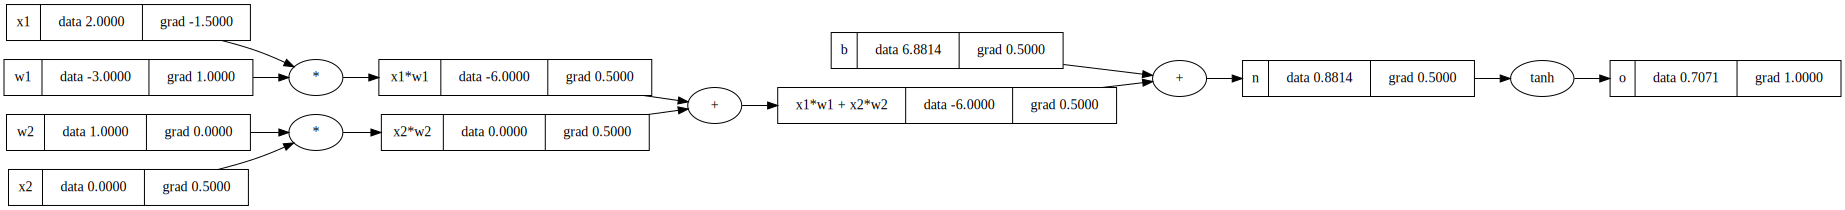

In [21]:
def test():
    # inputs x1, x2
    x1 = Value(2.0).label("x1")
    x2 = Value(0.0).label("x2")
    # weights w1, w2
    w1 = Value(-3.0).label("w1")
    w2 = Value(1.0).label("w2")
    # bias of the neuron
    b = Value(6.8813735870195432).label("b")
    # x1*w1 + x2*w2 + b
    x1w1 = (x1 * w1).label("x1*w1")
    x2w2 = (x2 * w2).label("x2*w2")
    x1w1x2w2 = (x1w1 + x2w2).label("x1*w1 + x2*w2")
    n = (x1w1x2w2 + b).label("n")
    o = n.tanh().label("o")

    o.grad = 1.0
    o._backward()
    n._backward()
    b._backward()
    x1w1x2w2._backward()
    x1w1._backward()
    x2w2._backward()
    x1._backward()
    x2._backward()
    w1._backward()
    w2._backward()

    return draw_dot(o)


test()


### For a whole expression graph

#### Andrej Karpathy's implementation (topological sort)

```python
def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()
```

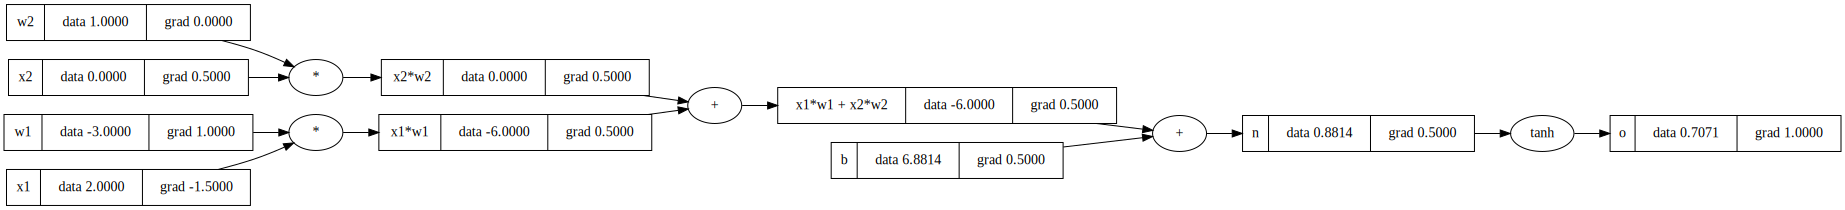

In [22]:
def test():
    # inputs x1, x2
    x1 = Value(2.0).label("x1")
    x2 = Value(0.0).label("x2")
    # weights w1, w2
    w1 = Value(-3.0).label("w1")
    w2 = Value(1.0).label("w2")
    # bias of the neuron
    b = Value(6.8813735870195432).label("b")
    # x1*w1 + x2*w2 + b
    x1w1 = (x1 * w1).label("x1*w1")
    x2w2 = (x2 * w2).label("x2*w2")
    x1w1x2w2 = (x1w1 + x2w2).label("x1*w1 + x2*w2")
    n = (x1w1x2w2 + b).label("n")
    o = n.tanh().label("o")

    o.grad = 1.0
    o.backward()

    return draw_dot(o)


test()


#### My implementation

```python
def backward(self):
    self._backward()
    for child in self._prev:
        child.backward()
```

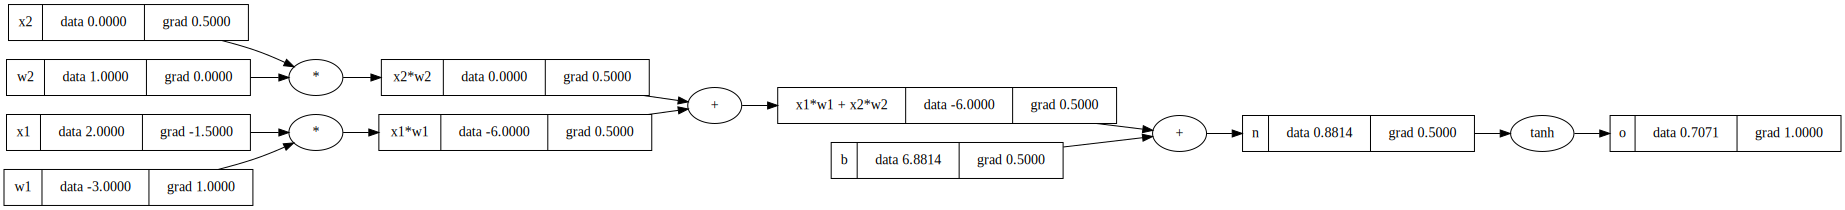

In [23]:
def test():
    # inputs x1, x2
    x1 = Value(2.0).label("x1")
    x2 = Value(0.0).label("x2")
    # weights w1, w2
    w1 = Value(-3.0).label("w1")
    w2 = Value(1.0).label("w2")
    # bias of the neuron
    b = Value(6.8813735870195432).label("b")
    # x1*w1 + x2*w2 + b
    x1w1 = (x1 * w1).label("x1*w1")
    x2w2 = (x2 * w2).label("x2*w2")
    x1w1x2w2 = (x1w1 + x2w2).label("x1*w1 + x2*w2")
    n = (x1w1x2w2 + b).label("n")
    o = n.tanh().label("o")

    o.grad = 1.0
    o.my_backward()

    return draw_dot(o)


test()


## Fixing a backprop bug when one node is used multiple times

The bug overrides the gradients, instead of accumulating them.

In [24]:
class BuggyValue(Value):
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
        out = Value(
            data=self.data + other.data,
            _op="+",
            _children=(self, other)
        )

        def _backward():
            # not adding the gradient, should be:
            # self.grad += out.grad
            self.grad = out.grad
            # not adding the gradient, should be:
            # other.grad += out.grad
            other.grad = out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other).label(f"{other}")
        out = Value(
            data=self.data * other.data,
            _op="*",
            _children=(self, other)
        )

        def _backward():
            # not adding the gradient, should be:
            # self.grad += other.data * out.grad
            self.grad = other.data * out.grad
            # not adding the gradient, should be:
            # other.grad += self.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out


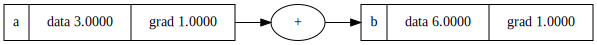

In [25]:
def test():
    a = BuggyValue(3.0).label("a")
    b = (a + a).label("b")
    b.backward()
    return draw_dot(b)


test()


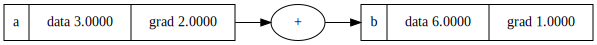

In [26]:
def test():
    a = Value(3.0).label("a")
    b = (a + a).label("b")
    b.backward()
    return draw_dot(b)


test()


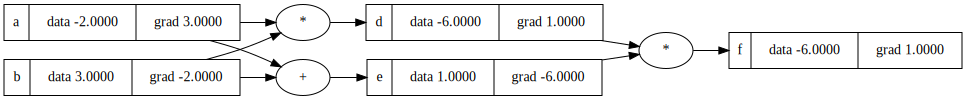

In [27]:
def test():
    a = BuggyValue(-2.0).label("a")
    b = BuggyValue(3.0).label("b")
    d = (a * b).label("d")
    e = (a + b).label("e")
    f = (d * e).label("f")
    
    f.backward()
    
    return draw_dot(f)


test()


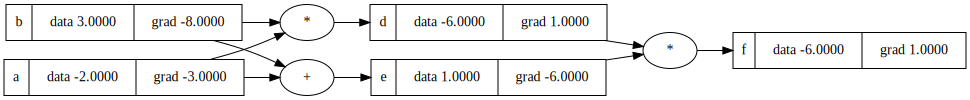

In [28]:
def test():
    a = Value(-2.0).label("a")
    b = Value(3.0).label("b")
    d = (a * b).label("d")
    e = (a + b).label("e")
    f = (d * e).label("f")
    
    f.backward()
    
    return draw_dot(f)


test()


## Exercising with more operations

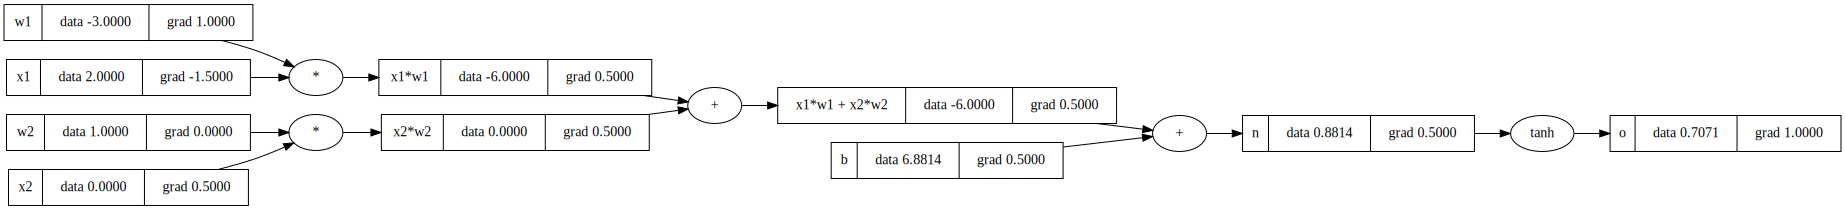

In [29]:
def test():
    # inputs x1, x2
    x1 = Value(2.0).label("x1")
    x2 = Value(0.0).label("x2")
    # weights w1, w2
    w1 = Value(-3.0).label("w1")
    w2 = Value(1.0).label("w2")
    # bias of the neuron
    b = Value(6.8813735870195432).label("b")
    # x1*w1 + x2*w2 + b
    x1w1 = (x1 * w1).label("x1*w1")
    x2w2 = (x2 * w2).label("x2*w2")
    x1w1x2w2 = (x1w1 + x2w2).label("x1*w1 + x2*w2")
    n = (x1w1x2w2 + b).label("n")
    o = n.tanh().label("o")
    o.backward()
    return draw_dot(o)


test()


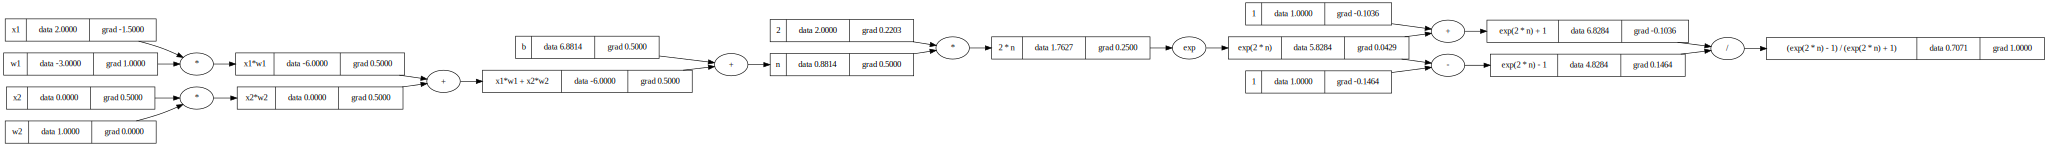

In [30]:
def test():
    # inputs x1, x2
    x1 = Value(2.0).label("x1")
    x2 = Value(0.0).label("x2")
    # weights w1, w2
    w1 = Value(-3.0).label("w1")
    w2 = Value(1.0).label("w2")
    # bias of the neuron
    b = Value(6.8813735870195432).label("b")
    # x1*w1 + x2*w2 + b
    x1w1 = (x1 * w1).label("x1*w1")
    x2w2 = (x2 * w2).label("x2*w2")
    x1w1x2w2 = (x1w1 + x2w2).label("x1*w1 + x2*w2")
    n = (x1w1x2w2 + b).label("n")
    # ----
    e = (2*n).exp()
    o = (e - 1) / (e + 1)
    o._label = o._exp_label
    # ----
    o.backward()
    return draw_dot(o)


test()
